In [33]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from tqdm import tqdm
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

import numpy as np
import seaborn as sns
import nltk
import re

In [2]:
twenty_all = fetch_20newsgroups(subset='all', shuffle=True)

# Data Preprocessing

* Cleaning alphanumeric symbols with regular expresions
* Removing stopwords
* Applying stemming


In [3]:
def process_data(dataset):
    stemmer = PorterStemmer()
    data = list()
    
    for article in tqdm(dataset.data):
        article = re.sub(r'[^\w]', ' ', article).strip()
        filtered_article = [stemmer.stem(word) for word in word_tokenize(article) if not word in stopwords.words('english')]
        new_article = ''
        
        for filtered_word in filtered_article:
            new_article += filtered_word + ' '
            
        data.append(new_article)
        
    dataset.data = data
    
    return dataset

In [4]:
twenty_all = process_data(twenty_all)

100%|██████████| 18846/18846 [06:49<00:00, 46.00it/s]


# Creating Sparse Matrixes and Models

* Applying bag of words
* Applying TF + IDF transformation
* Creating different models: MultinomialNB, Random Forest, SGD, KNN
* Checking models' accuracy using cross validation


In [39]:
c_vect = CountVectorizer()
tfidf = TfidfTransformer()

X = c_vect.fit_transform(twenty_all.data)
X = tfidf.fit_transform(X)

y = twenty_all.target

In [8]:
#MultinomialNB

text_clf = MultinomialNB()

scores = cross_val_score(text_clf, X, y, cv=5, scoring='accuracy', n_jobs=-1)
print('Scores', scores)
print('Mean Score', np.mean(scores))

Scores [0.86525199 0.87874768 0.87370655 0.86733882 0.86335898]
Mean Score 0.8696808038212052


In [11]:
#KNN Classifier

text_clf = KNeighborsClassifier(n_jobs=-1)
scores = cross_val_score(text_clf, X, y, cv=5, scoring='accuracy', n_jobs=-1)
print('Scores', scores)
print('Mean Score', np.mean(scores))

Scores [0.80450928 0.81321305 0.81241709 0.8137437  0.80578403]
Mean Score 0.8099334301255601


In [13]:
#SGD Classifier

text_clf = SGDClassifier(n_jobs=-1, random_state=42)
scores = cross_val_score(text_clf, X, y, cv=5, scoring='accuracy', n_jobs=-1)
print('Scores', scores)
print('Mean Score', np.mean(scores))

Scores [0.92228117 0.92597506 0.92358716 0.91748474 0.91562749]
Mean Score 0.9209911233129684


In [14]:
#Random Forest Classifier

text_clf = RandomForestClassifier(n_jobs=-1)
scores = cross_val_score(text_clf, X, y, cv=5, scoring='accuracy', n_jobs=-1)
print('Scores', scores)
print('Mean Score', np.mean(scores))

Scores [0.86074271 0.86203237 0.86203237 0.85327673 0.84876625]
Mean Score 0.8573700852902324


# Checking Models' Accuracy on Training and Testing Datasets

In [40]:
c_vect = CountVectorizer()
tfidf = TfidfTransformer()

X = c_vect.fit_transform(twenty_all.data)
X = tfidf.fit_transform(X)

y = twenty_all.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [41]:
#Train Random Forest Classifier
forest = RandomForestClassifier(n_jobs=-1, random_state=42)
forest.fit(X_train, y_train)
predicted = forest.predict(X_test)
np.mean(predicted == y_test)

0.8541114058355438

In [42]:
#Train SGD Classifier

sgd = SGDClassifier(loss='hinge', penalty='l2', alpha=1e-4, n_iter_no_change=5, random_state=42, n_jobs=-1)
sgd.fit(X_train, y_train)
predicted = sgd.predict(X_test)
np.mean(predicted == y_test)

0.9159151193633952

In [43]:
#Train Multinomial NB Classifier

bayes = MultinomialNB()
bayes.fit(X_train, y_train)
predicted = bayes.predict(X_test)
np.mean(predicted == y_test)

0.86684350132626

# Confusion Matrix Visualization
* Using seaborn heatmap to visualize final model's performances

In [44]:
sgd_prediction = sgd.predict(X_test)
forest_prediction = forest.predict(X_test)
bayes_prediction = bayes.predict(X_test)

In [45]:
sgd_cf = confusion_matrix(sgd_prediction, y_test)
forest_cf = confusion_matrix(forest_prediction, y_test)
bayes_cf = confusion_matrix(bayes_prediction, y_test)

categories = list(twenty_test.target_names)

<AxesSubplot:>

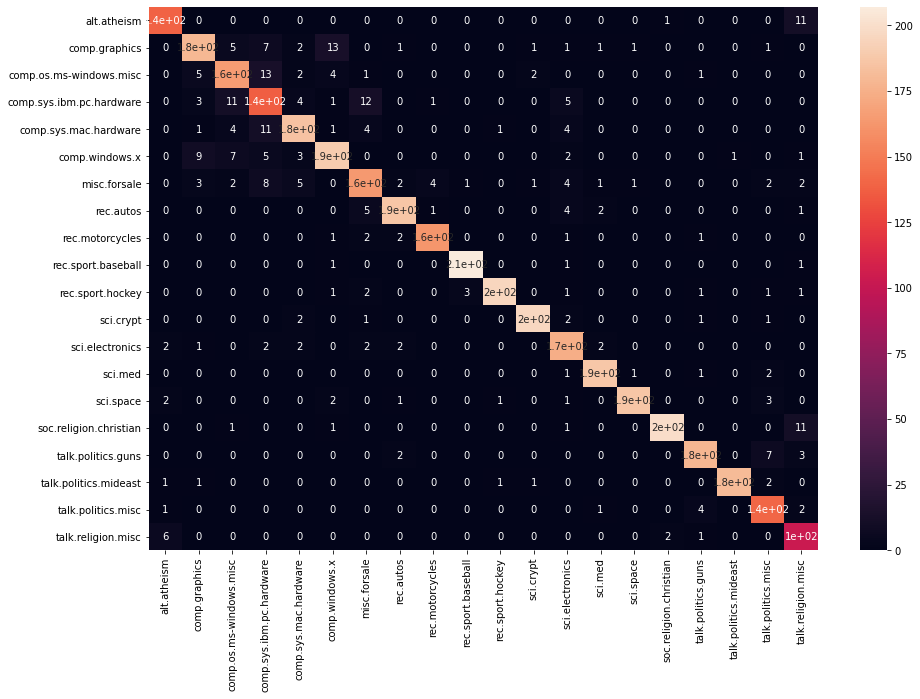

In [46]:
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(sgd_cf, annot=True, xticklabels=categories, yticklabels=categories, ax=ax)

**SGD Classifier** confusion matrix shows a very good performance in all categories.

<AxesSubplot:>

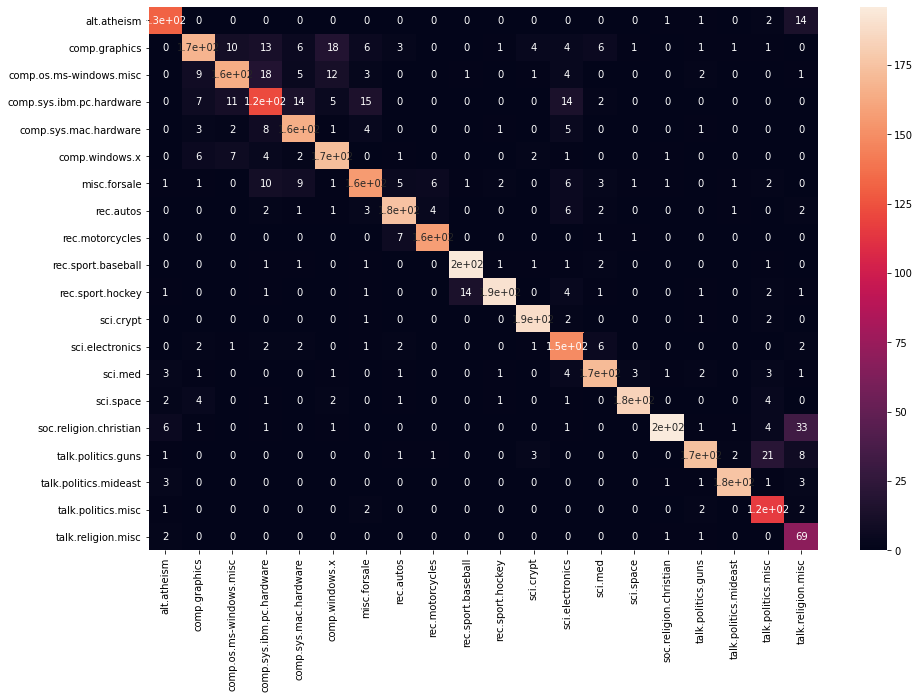

In [47]:
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(forest_cf, annot=True, xticklabels=categories, yticklabels=categories, ax=ax)

**Random Forest Classifier's** confusion matrix shows a poor performance in **talk.religion.misc** category. In a lot of cases, this category is classified as **soc.religion.christian**.

<AxesSubplot:>

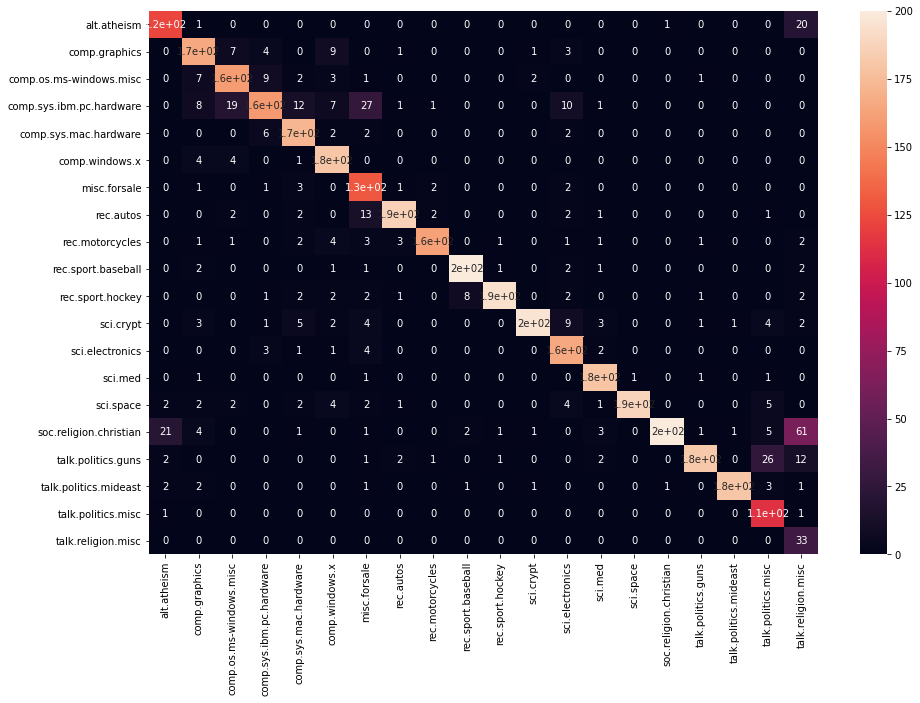

In [48]:
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(bayes_cf, annot=True, xticklabels=categories, yticklabels=categories, ax=ax)

**MultinomialNB's** confusion matrix shows a very poor performance in **talk.politics.misc** and **talk.religion.misc** categories. In a lot of cases, these categories are classified as **talk.politics.guns** and **soc.religion.christian**.

# Conclusion

Without too much hyperparameter fine tunning, **SGD Classifier** is the best model so far with an accuracy of **91.59%**.
I have also tried **MultinomialNB** and **Random Forest Classifier** but their accuracy is much lower: **86.68%** and **85.41%**.